# Optimizing Deep Q Learning with SHAP Explanations
Exploring Minimum Experience Replay Buffer Sizes for Reinforcement Learning
### Installation Instructions
* Windows 10 was used.
* VS Code was used may ask to install ipykernal package to run notebook
* Install Python 3.8. Visit: https://www.python.org/downloads/release/python-380/
* Python Virtual environment. c:\Python38\python -m venv c:\path\to\venv_research Visit: https://docs.python.org/3/library/venv.html
* PyTorch on Windows only supports Python 3.7-3.9; Python 2.x is not supported. CUDA is required: For more info visit: https://pytorch.org/get-started/locally/
* pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
* pip install matplotlib
* Install Open-Ai's Gym which is now maintained by Gymnasium, e.g import gymnasium as gym. Visit: https://gymnasium.farama.org/environments/classic_control/
* pip install gymnasium[classic-control]
* pip install box2d (swig may fail if pip install gymnasium[box2d])
* pip install gymnasium[box2d]
* pip install numpy==1.23.5 (needed for a shap dependency)
* pip install shap
* Install custom third party addiction simulator ensure hrl_gym folder available. Go to hrl_gym where setup.py is located and run pip install -e .

## Import Libraries

In [1]:
#basic
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

#pytorch for gpu processing of ML model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

#hide pytorch warnings (should eventually be resolved)
import warnings
warnings.filterwarnings("ignore")

#Simulations
import hrl_gym #simulate addiction
import gymnasium as gym

#!pip install shap
#github.com/slundberg/shap, 
#https://www.youtube.com/watch?v=Ty7qf3mV_Qc, 
#https://github.com/dynamik1703/gym_longicontrol/blob/master/Jupyter/LongiControl_SHAP.ipynb
# https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

from sklearn.model_selection import train_test_split #for splitting memory into training and testing

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from statsmodels.formula.api import ols

import shap 
shap.initjs() #call for each plot

## Deep Q-Learning Agent

### Neural Network Model

In [2]:
class Network(nn.Module):  
    def __init__(self, input_size, nb_action):
        #ref: https://discuss.pytorch.org/t/super-model-in-init/97426
        #super(Network, self).__init__()
        super().__init__() #pytorch's NN model
        self.input_size = input_size
        self.nb_action = nb_action
        self.fc1 = nn.Linear(input_size, 30)#arbitrarily chose 30 hidden layers
        self.fc2 = nn.Linear(30, nb_action)
    
    #base pytorch NN model runs and we override the
    #forward function with our own relu activation function
    def forward(self, state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

### Experience Replay Model
This model is used for training our DQN model. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [3]:
class ReplayMemory(): 
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0] #forget first transition
    
    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size)) 
        return map(lambda x: Variable(torch.cat(x, 0)), samples) #tensor and gradient.
        #this contains sample of memory. get random sample from memory with given size
        # before list = [[state,action,reward], [state,action,reward]] zip*=> [[state], [action], [reward]]
        #the * operator unpacks a list and applies it to a function
        #a pytorch variable contains a tensor and a gradient. in order for pytorch to differenciate with respect to a tensor, we need a tensor and gradient
        # For each batch within a sample, we then have to concatenate it to the first dimension because 
        # everything needs to be aligned so state action and reward align to same time t
        # Lambda is used to do a short computation inline without def and if, etc.
        

### Agent (DQN Learning System )
Comprised of a neural network model and a memory model. 
* The NN takes in observation of sensor data (brain chemicals) and chooses actions based on the relu activation function. 
* The agent will sample some of the sensor data and store in long term memory to be reused later for training. 
* We also use the Adam Optimisation algorithm. This is an extension to stocastic gradient desent to update weights of the neural network. 

In [4]:
class Dqn():
    def __init__(self, input_size, nb_action, gamma, capacity=100000, learning=0.001, temperature=100, sample_rate=100):
        self.gamma = gamma
        self.reward_window = []
        self.cumulative_rewards = []
        self.model = Network(input_size, nb_action)
        self.memory = ReplayMemory(capacity) #100k
        self.sample_rate = sample_rate
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning)
        self.last_state = torch.Tensor(input_size).unsqueeze(0)
        self.last_action = 0
        self.last_reward = 0
        self.temp = temperature
        self.explainer = None #used to calculate shap values
        self.shap_values = [] #store collected shap values

        #create table for memory data collection
        self.df = pd.DataFrame(columns=['batch_state', 'batch_next_state', 'batch_action', 'batch_reward'])

    # select action for x duration
    def select_action(self, state):
        #softmax converts numbers into probabilities
        #Q values are the output of the neural network
            #view q values
        q_value_tensor = self.model(Variable(state, volatile = True)) 
        q_values = [q_value.detach().numpy() for q_value in q_value_tensor]
            #print(q_values)
            #viz q value for each action, (T value by user choice)
            #pie chart 0/1 #seperate action
        # Temperature value = 100. closer to zero the less sure the NN will be to taking the action
        probs = F.softmax(self.model(Variable(state, volatile = True))*self.temp) # T=100
        
        action_prob = [prob.detach().numpy() for prob in probs]

        action = probs.multinomial(num_samples=1) # action taken
        #q_values[0][action] #quality of taking action in state
        #action_prob[0][action] #probability of taking action

        #return the action taken, q values and probabilities of taking action given state.
        #return action.data[0,0], q_values[0][action], action_prob[0][action]
        return action.data[0,0], q_values, action_prob
    
    #When ai reaches a new state we update everything
    #update action, last action becomes the new action but also the last state becomes the new state and last reward becomes the new state
    # we then get this new transition and update our reward window to track training progress and exploration
    def update(self, reward, new_signal):
        new_state = torch.Tensor(new_signal).float().unsqueeze(0)
        self.memory.push((self.last_state, new_state, torch.LongTensor([int(self.last_action)]), torch.Tensor([self.last_reward])))
        action, q, p = self.select_action(new_state)
        if len(self.memory.memory) > self.sample_rate: #100
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(self.sample_rate)

            #first converting tensors to numpy arrays
            batch_state_np = batch_state.numpy()
            batch_next_state_np = batch_next_state.numpy()
            batch_action_np = batch_action.numpy()
            batch_reward_np = batch_reward.numpy()

            # Split the data into training and testing sets
            state_train, state_test, next_state_train, next_state_test, action_train, action_test, reward_train, reward_test = train_test_split(
                batch_state_np, batch_next_state_np, batch_action_np, batch_reward_np, test_size=0.1, random_state=42)
            
            # Convert back to tensors
            state_train = torch.tensor(state_train)
            next_state_train = torch.tensor(next_state_train)
            reward_train = torch.tensor(reward_train)
            action_train = torch.tensor(action_train)
            state_test = torch.tensor(state_test)
            next_state_test = torch.tensor(next_state_test)
            reward_test = torch.tensor(reward_test)
            action_test = torch.tensor(action_test)

            self.df.loc[len(self.df)] = [state_test, next_state_test, reward_test, action_test]

            self.learn(state_train, next_state_train, reward_train, action_train)
            #self.learn(batch_state, batch_next_state, batch_reward, batch_action)
            #X=batch_state and y=batch_next_state
        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        self.reward_window.append(reward)
        self.cumulative_rewards.append(sum(self.reward_window))
        #if len(self.reward_window) > 1000:
        #    del self.reward_window[0]
        return action, q, p
    
    #to train our AI
    #forward propagation then backproagation
    # get our output, target, compare our output to the target to compute the loss error
    # backproagate loss error into the nn and use stochastic gradient descent we update the weights according to how much they contributed to the loss error
    def learn(self, batch_state, batch_next_state, batch_reward, batch_action):
        #when we pass in batch state the output will be all possible actions
        # we use gather passing in 1 and batch action because we only want the chosen action
        # however batch_state has a fake dimention from unsqueeze in __init__ of NN and batch action doesn't
        outputs = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1) #pass state into neural network input layer., gather outputs a new tensor. input dimension
        #gets the q values for all the next states with respect to action (i.e 1) then get the max
        next_outputs = self.model(batch_next_state).detach().max(1)[0]
        target = self.gamma*next_outputs + batch_reward
        td_loss = F.smooth_l1_loss(outputs, target)
        self.optimizer.zero_grad()
        td_loss.backward(retain_graph = True)
        self.optimizer.step()
    
    def score(self):
        """ Current sum of all values in the reward window """
        return sum(self.reward_window)
    
    def cumulative_reward(self):
        """ Sum of all values in the reward window at step/time"""
        return self.cumulative_rewards
    
    def rewards(self):
        """ current value in the reward window at step/time"""
        return self.reward_window
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')
    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")

In [ ]:
#create table for evaluating capacity against reward
df_rewards = pd.DataFrame(columns=['capacity', 'time_sec', 'reward'])

## Cartpole Simulator Experiment
Simulate balancing a pole. This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “[Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem](https://ieeexplore.ieee.org/document/6313077)”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

reward is 1 if angle of pole is less than 12 degs and zero otherwise.
actions are 0 to push cart to the left and 1 to push cart to the right

simple hard coded solution is to move car in direction pole is moving. this requires understanding of mechnaics and doesn't generalise to other problems

### 1,000,000 Capacity Size

#### Setup Environment

In [5]:
env = gym.make('CartPole-v1')#render_mode='human'
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

2
Discrete(2)
4
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


#### Create Agent

In [6]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 1000000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

#### Simulate the environment

In [7]:
episodes = 100
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated #max duration should be 200 for episode length
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [0.2684777  0.5751308  0.21403883 0.4349825 ], action: 1, score: 83.0
episode: 1, obs: [0.10325695 0.5222779  0.21628246 0.45701137], action: 1, score: 153.0
episode: 2, obs: [0.11238078 0.5624393  0.21939637 0.31974107], action: 1, score: 57.0
episode: 3, obs: [0.12664577 0.29229426 0.22605833 0.6417343 ], action: 1, score: 90.0
episode: 4, obs: [0.04729403 0.13826862 0.21347812 0.69462854], action: 0, score: 29.0
episode: 5, obs: [-0.08102669 -0.0647044   0.21963562  0.724418  ], action: 1, score: 40.0
episode: 6, obs: [-0.11671867 -0.3930882   0.21704799  1.1224866 ], action: 0, score: 16.0
episode: 7, obs: [-0.14240633 -0.23105511  0.21547349  0.7854286 ], action: 1, score: 21.0
episode: 8, obs: [-0.16876452 -0.2188504   0.21603756  0.7967118 ], action: 1, score: 23.0
episode: 9, obs: [-0.10637834 -0.57239157  0.2261854   1.3373408 ], action: 0, score: 17.0
episode: 10, obs: [-0.10151976 -0.37767804  0.22852197  0.98274773], action: 1, score: 18.0
episode: 11, obs:

#### HOW did the agent performed?

##### Agent's final score

In [8]:
#Current sum of all values in the reward window
print(agent.score())

26556.0


##### Rewards at given time/step

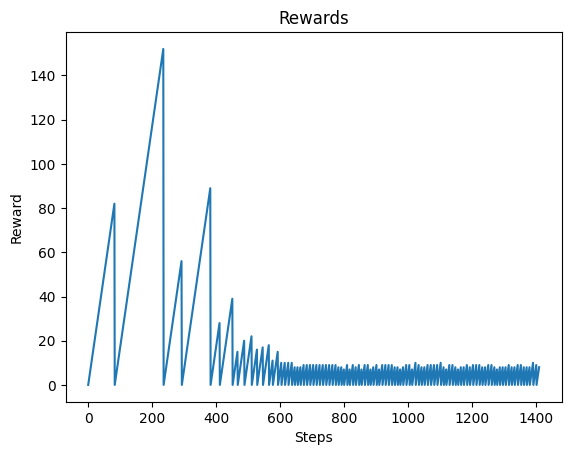

In [9]:
# Iterate over the rows of env.df and append them to df_rewards
for index, row in env.df.iterrows():
    new_row = ["1M", row['time_sec'], row["reward"]]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

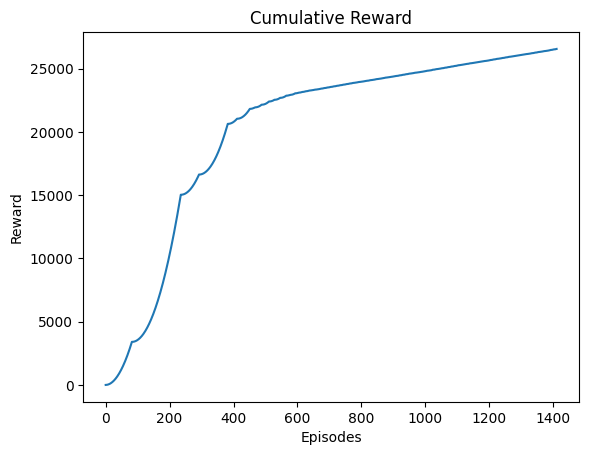

In [10]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [11]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
len(agent.df)

1312

In [12]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.0265), tensor(-0.1965), tensor(-0....  \
1  [[tensor(-0.0109), tensor(0.2399), tensor(0.01...   
2  [[tensor(0.0924), tensor(0.2300), tensor(0.037...   
3  [[tensor(-0.0265), tensor(-0.1965), tensor(-0....   
4  [[tensor(0.1023), tensor(0.0332), tensor(0.044...   

                                    batch_next_state   
0  [[tensor(-0.0304), tensor(-0.0010), tensor(-0....  \
1  [[tensor(-0.0061), tensor(0.0446), tensor(0.00...   
2  [[tensor(0.0970), tensor(0.0344), tensor(0.037...   
3  [[tensor(-0.0304), tensor(-0.0010), tensor(-0....   
4  [[tensor(0.1029), tensor(0.2277), tensor(0.051...   

                                        batch_action   
0  [tensor(15.), tensor(4.), tensor(67.), tensor(...  \
1  [tensor(11.), tensor(14.), tensor(16.), tensor...   
2  [tensor(51.), tensor(3.), tensor(82.), tensor(...   
3  [tensor(15.), tensor(13.), tensor(12.), tensor...   
4  [tensor(54.), tensor(66.), tensor(24.), tensor...   

                                        batch_reward  
0  [tensor(1), tensor(0), tensor(1), tensor(1), t...  
1  [tensor(0), tensor(0), tensor(1), tensor(0), t...  
2  [tensor(0), tensor(0), tensor(1), tensor(0), t...  
3  [tensor(1), tensor(0), tensor(1), tensor(0), t...  
4  [tensor(1), tensor(0), tensor(1), tensor(0), t...

In [13]:
agent.df.batch_state.values #cart position, cart velocity, pole angle, pole angular velocity

array([tensor([[-0.0265, -0.1965, -0.0279,  0.2571],
               [-0.0298, -0.0041, -0.0217,  0.0242],
               [ 0.1565,  0.2163,  0.0925,  0.3184],
               [ 0.0256,  0.0424,  0.0092,  0.1423],
               [ 0.0479,  0.0412,  0.0104,  0.1697],
               [ 0.1081,  0.2262,  0.0606,  0.0995],
               [-0.0265, -0.0018, -0.0274, -0.0269],
               [ 0.2099,  0.3969,  0.1500,  0.3487],
               [ 0.0653, -0.1553,  0.0183,  0.4920],
               [ 0.1339,  0.2227,  0.0592,  0.1764]]),
       tensor([[-1.0942e-02,  2.3987e-01,  1.0532e-02, -2.0213e-01],
               [-4.5960e-04,  4.4392e-02,  4.4309e-03,  9.8538e-02],
               [-2.5876e-03,  4.4237e-02,  1.4254e-02,  1.0196e-01],
               [-1.7029e-03,  2.3915e-01,  1.6293e-02, -1.8619e-01],
               [ 1.6078e-01,  4.1003e-01,  9.8891e-02,  5.6275e-02],
               [ 6.5303e-02, -1.5530e-01,  1.8298e-02,  4.9201e-01],
               [ 6.2197e-02,  3.9562e-02,  2.8138e-02,

In [14]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [15]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.0265, -0.1965, -0.0279,  0.2571],
        [-0.0298, -0.0041, -0.0217,  0.0242],
        [ 0.1565,  0.2163,  0.0925,  0.3184],
        ...,
        [-0.1784, -1.7485,  0.1828,  2.7360],
        [-0.1040, -1.7942,  0.1602,  2.6188],
        [-0.0777, -0.9654,  0.0280,  1.4740]])


13120

In [16]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 9.6648e-02,  3.3046e-01,  2.0269e-01,  6.7966e-01],
        [ 7.9267e-03,  2.1627e-01,  5.2600e-02, -7.4671e-02],
        [ 1.0293e-01,  2.2770e-01,  5.1752e-02,  6.6470e-02],
        [ 6.5303e-02, -1.5530e-01,  1.8298e-02,  4.9201e-01],
        [ 1.5032e-02, -1.6276e-01, -6.2041e-03,  2.6362e-01],
        [-5.9733e-02,  1.8306e-01,  1.7894e-02, -9.3434e-02],
        [-5.2923e-02,  1.8203e-01,  2.2791e-02, -7.0582e-02],
        [-2.2048e-03,  2.4659e-02,  4.7155e-02,  1.4091e-01],
        [-3.4381e-02, -1.9520e-01, -1.9996e-02,  2.2776e-01],
        [ 2.5597e-02,  4.2410e-02,  9.2401e-03,  1.4226e-01],
        [ 9.0200e-02,  1.8358e-01,  1.7172e-01,  6.5561e-01],
        [-8.0540e-02,  1.8514e-01,  1.1532e-02, -1.3920e-01],
        [-1.0179e-01,  1.8703e-01,  1.4922e-02, -1.8104e-01],
        [-3.7919e-02,  1.9216e-01, -8.8247e-03, -2.9423e-01],
        [ 3.9424e-02,  8.7600e-03,  9.7544e-02,  4.9362e-01],
        [ 1.7335e-02,  2.1322e-01,  6.0304e-02, -7.1092e-03],
        

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [17]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [18]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [19]:
shap_values

[array([[-4.82435894e+00, -1.48172712e+01,  1.68013992e+01,
          7.03872452e+01],
        [ 3.48424822e-01, -7.96564245e+00,  2.49808073e+00,
         -1.75313892e+01],
        [-5.19048643e+00, -8.65146160e+00,  2.41726208e+00,
         -1.08124053e+00],
        [-2.99685526e+00,  1.43297377e+01, -7.70881295e-01,
          4.85163193e+01],
        [-6.58456013e-02,  1.47777729e+01, -3.10591698e+00,
          2.18964882e+01],
        [ 4.29323864e+00, -5.97283316e+00, -8.09416831e-01,
         -1.97182178e+01],
        [ 3.89618587e+00, -5.91067648e+00, -3.42678726e-01,
         -1.70548592e+01],
        [ 9.39131677e-01,  3.53185368e+00,  1.97914600e+00,
          7.59526968e+00],
        [ 2.81511927e+00,  1.67242508e+01, -4.42030859e+00,
          1.77177353e+01],
        [-6.81808591e-01,  2.46671724e+00, -1.63409960e+00,
          7.75220490e+00],
        [-4.44841814e+00, -6.00394249e+00,  1.38504658e+01,
          6.75835037e+01],
        [ 5.50641060e+00, -6.09732294e+00, 

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

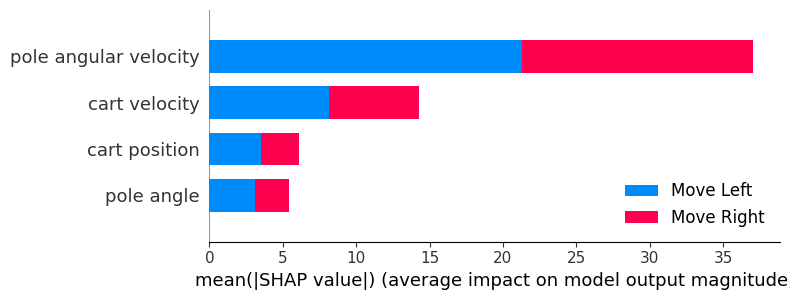

In [20]:
shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'], class_names=['Move Left', 'Move Right']) #env.df.columns not the best

In [21]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'])

### 500,000 Capacity Size

#### Setup Environment

In [22]:
env = gym.make('CartPole-v1')#render_mode='human'
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

2
Discrete(2)
4
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


#### Create Agent

In [23]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 500000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

#### Simulate the environment

In [24]:
episodes = 100
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated #max duration should be 200 for episode length
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [ 0.14446816  2.0011039  -0.23103364 -3.010781  ], action: 1, score: 10.0
episode: 1, obs: [ 0.10267503  1.7564692  -0.22289637 -2.7622514 ], action: 1, score: 9.0
episode: 2, obs: [ 0.16090864  1.793284   -0.22729722 -2.8262067 ], action: 1, score: 9.0
episode: 3, obs: [ 0.17219904  1.9092866  -0.22576128 -3.0090034 ], action: 1, score: 10.0
episode: 4, obs: [ 0.2368995   1.7431709  -0.26020768 -2.7043586 ], action: 0, score: 11.0
episode: 5, obs: [ 0.16303867  1.7303206  -0.22792827 -2.8417988 ], action: 1, score: 9.0
episode: 6, obs: [ 0.14463854  1.5825632  -0.22925225 -2.418185  ], action: 0, score: 10.0
episode: 7, obs: [ 0.12094037  1.7478273  -0.22481468 -2.8235598 ], action: 1, score: 9.0
episode: 8, obs: [ 0.10344791  1.760355   -0.24533534 -2.8318627 ], action: 1, score: 9.0
episode: 9, obs: [ 0.17600374  1.9876441  -0.24904364 -3.0893004 ], action: 1, score: 10.0
episode: 10, obs: [ 0.17947324  1.7919693  -0.23297822 -2.8341613 ], action: 1, score: 9.0
epis

#### HOW did the agent performed?

##### Agent's final score

In [25]:
#Current sum of all values in the reward window
print(agent.score())

3860.0


##### Rewards at given time/step

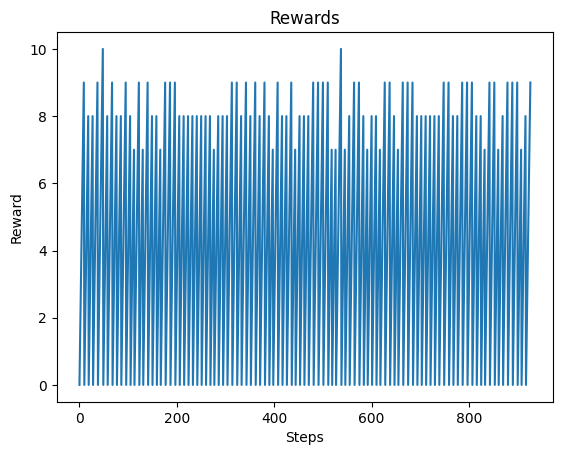

In [26]:
# Iterate over the rows of env.df and append them to df_rewards
for index, row in env.df.iterrows():
    new_row = ["500k", row['time_sec'], row["reward"]]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

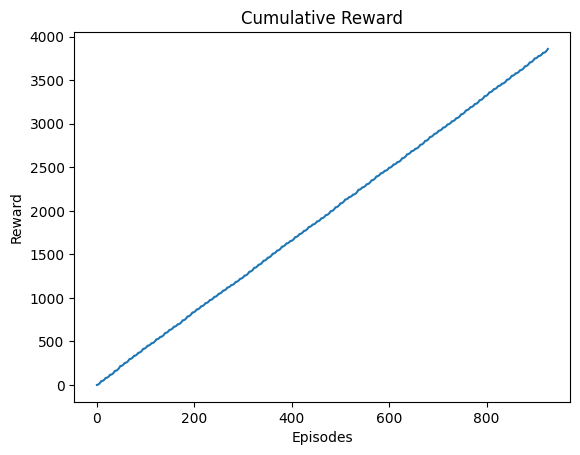

In [27]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [28]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
len(agent.df)

827

In [29]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.0628), tensor(1.3556), tensor(-0.13...  \
1  [[tensor(0.0196), tensor(0.4227), tensor(-0.01...   
2  [[tensor(-0.0218), tensor(0.6026), tensor(0.01...   
3  [[tensor(0.1379), tensor(1.7134), tensor(-0.17...   
4  [[tensor(0.0404), tensor(0.8134), tensor(-0.04...   

                                    batch_next_state   
0  [[tensor(0.0899), tensor(1.5517), tensor(-0.17...  \
1  [[tensor(0.0280), tensor(0.6180), tensor(-0.02...   
2  [[tensor(-0.0097), tensor(0.7976), tensor(-0.0...   
3  [[tensor(0.0258), tensor(-0.0145), tensor(0.04...   
4  [[tensor(0.0567), tensor(1.0091), tensor(-0.06...   

                                        batch_action   
0  [tensor(7.), tensor(7.), tensor(2.), tensor(1....  \
1  [tensor(2.), tensor(0.), tensor(9.), tensor(4....   
2  [tensor(3.), tensor(6.), tensor(1.), tensor(8....   
3  [tensor(9.), tensor(7.), tensor(5.), tensor(1....   
4  [tensor(4.), tensor(9.), tensor(8.), tensor(2....   

                                        batch_reward  
0  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
1  [tensor(1), tensor(1), tensor(0), tensor(1), t...  
2  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
3  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
4  [tensor(1), tensor(0), tensor(1), tensor(1), t...

In [30]:
agent.df.batch_state.values #cart position, cart velocity, pole angle, pole angular velocity

array([tensor([[ 0.0628,  1.3556, -0.1321, -2.1523],
               [ 0.0812,  1.3215, -0.0851, -2.0227],
               [ 0.0196,  0.4227, -0.0126, -0.6164],
               [-0.0342,  0.2131,  0.0254, -0.2381],
               [-0.0260,  0.6318,  0.0108, -0.8257],
               [-0.0372, -0.0050, -0.0129,  0.0427],
               [ 0.0586,  1.1258, -0.0508, -1.7147],
               [ 0.0055, -0.0436,  0.0328,  0.0132],
               [ 0.0722,  1.5642, -0.1956, -2.4861],
               [ 0.0404,  0.8134, -0.0432, -1.2134]]),
       tensor([[ 0.0196,  0.4227, -0.0126, -0.6164],
               [-0.0372, -0.0050, -0.0129,  0.0427],
               [ 0.1091,  1.7760, -0.1762, -2.6523],
               [ 0.0591,  0.8119, -0.0485, -1.2141],
               [ 0.0762,  1.6091, -0.1308, -2.3396],
               [-0.0332,  0.3886, -0.0327, -0.5853],
               [ 0.0198,  0.8130, -0.0159, -1.1720],
               [-0.0137,  0.7798, -0.0621, -1.1943],
               [-0.0140,  0.3774, -0.0102, -

In [31]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [32]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 0.0628,  1.3556, -0.1321, -2.1523],
        [ 0.0812,  1.3215, -0.0851, -2.0227],
        [ 0.0196,  0.4227, -0.0126, -0.6164],
        ...,
        [ 0.0135,  0.4102, -0.0551, -0.6199],
        [ 0.0358, -0.0037, -0.0115,  0.0140],
        [ 0.0207,  1.1712, -0.0661, -1.7461]])


8270

In [33]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 6.8934e-02,  1.1903e+00, -1.3477e-01, -1.8774e+00],
        [-1.4032e-02,  3.7739e-01, -1.0159e-02, -6.1853e-01],
        [ 8.0261e-02,  1.3997e+00, -1.0420e-01, -2.0876e+00],
        [ 4.9053e-02,  9.9405e-01, -1.0369e-01, -1.5542e+00],
        [ 9.6942e-02,  1.3561e+00, -9.3376e-02, -2.0783e+00],
        [-3.3195e-02,  3.8857e-01, -3.2653e-02, -5.8526e-01],
        [ 5.4438e-02,  9.6488e-01, -2.8678e-02, -1.4667e+00],
        [-6.8174e-03,  9.7698e-01, -8.0394e-02, -1.5457e+00],
        [-3.3871e-02,  1.9571e-01, -3.4376e-02, -2.8381e-01],
        [ 2.5852e-02,  2.1946e-02, -6.7907e-03,  1.2731e-02],
        [ 2.0330e-02,  9.6369e-01, -6.5099e-02, -1.5193e+00],
        [-4.0361e-02,  4.0260e-02, -4.4224e-03, -2.9764e-02],
        [ 1.6431e-02, -9.3613e-03,  3.1402e-02, -3.3303e-02],
        [-1.5489e-02,  7.9128e-01, -6.5902e-02, -1.1748e+00],
        [-5.3844e-03, -1.1898e-02, -1.9849e-02,  1.3028e-02],
        [-3.7189e-02, -4.9614e-03, -1.2920e-02,  4.2676e-02],
        

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [34]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [35]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [36]:
shap_values

[array([[-2.74422497e-01,  3.27263165e+00,  6.99408770e-01,
          4.76395798e+00],
        [-7.14428484e-01, -2.28481388e+00, -1.34815812e-01,
         -5.39239025e+00],
        [-2.14353666e-01,  4.70454597e+00,  4.94719863e-01,
          6.45964241e+00],
        [-3.79860401e-01,  1.93123591e+00,  4.91310388e-01,
          2.15679860e+00],
        [-1.25883639e-01,  4.40628862e+00,  4.22283620e-01,
          6.38535643e+00],
        [-8.16055417e-01, -2.20835185e+00,  1.57710295e-02,
         -5.66084290e+00],
        [-3.51301908e-01,  1.73179460e+00, -1.08426474e-02,
          1.45064056e+00],
        [-6.76164210e-01,  1.81450093e+00,  3.35375607e-01,
          2.08806014e+00],
        [-8.19639802e-01, -3.52691936e+00,  2.73050144e-02,
         -8.09286308e+00],
        [-5.02905548e-01, -4.71489906e+00, -1.57367706e-01,
         -1.04853964e+01],
        [-5.32192647e-01,  1.72366917e+00,  2.32983798e-01,
          1.87468421e+00],
        [-8.54059696e-01, -4.58968830e+00, 

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

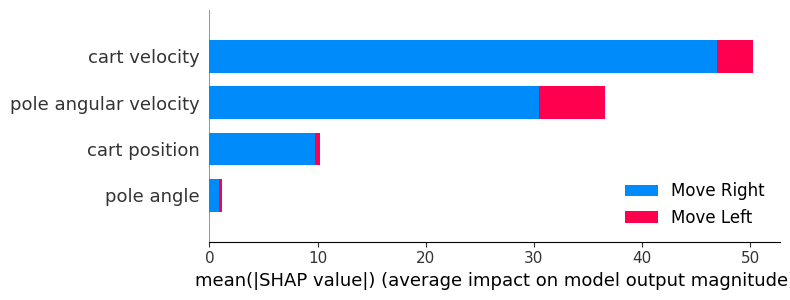

In [37]:
shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'], class_names=['Move Left', 'Move Right']) #env.df.columns not the best

In [38]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'])

### 100,000 Capacity Size

#### Setup Environment

In [39]:
env = gym.make('CartPole-v1')#render_mode='human'
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

2
Discrete(2)
4
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


#### Create Agent

In [40]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 100000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

#### Simulate the environment

In [41]:
episodes = 100
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated #max duration should be 200 for episode length
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [ 0.14446816  2.0011039  -0.23103364 -3.010781  ], action: 1, score: 10.0
episode: 1, obs: [ 0.10267503  1.7564692  -0.22289637 -2.7622514 ], action: 1, score: 9.0
episode: 2, obs: [ 0.16090864  1.793284   -0.22729722 -2.8262067 ], action: 1, score: 9.0
episode: 3, obs: [ 0.17219904  1.9092866  -0.22576128 -3.0090034 ], action: 1, score: 10.0
episode: 4, obs: [ 0.2368995   2.132273   -0.26020768 -3.27619   ], action: 1, score: 11.0
episode: 5, obs: [ 0.16303867  1.7303206  -0.22792827 -2.8417988 ], action: 1, score: 9.0
episode: 6, obs: [ 0.14463854  1.9719316  -0.22925225 -2.9931939 ], action: 1, score: 10.0
episode: 7, obs: [ 0.12094037  1.7478273  -0.22481468 -2.8235598 ], action: 1, score: 9.0
episode: 8, obs: [ 0.10344791  1.760355   -0.24533534 -2.8318627 ], action: 1, score: 9.0
episode: 9, obs: [ 0.17600374  1.9876441  -0.24904364 -3.0893004 ], action: 1, score: 10.0
episode: 10, obs: [ 0.17947324  1.7919693  -0.23297822 -2.8341613 ], action: 1, score: 9.0
epis

#### HOW did the agent performed?

##### Agent's final score

In [42]:
#Current sum of all values in the reward window
print(agent.score())

3860.0


##### Rewards at given time/step

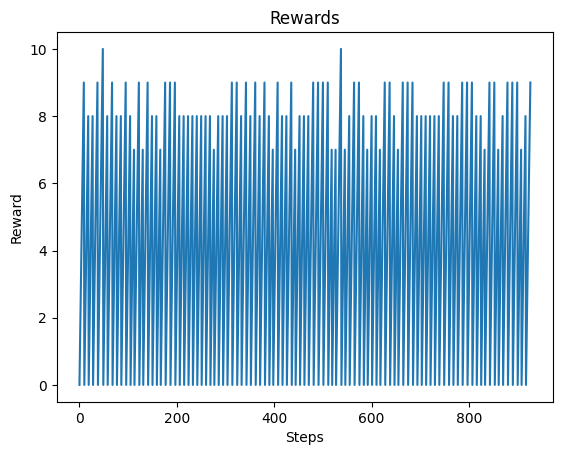

In [43]:
# Iterate over the rows of env.df and append them to df_rewards
for index, row in env.df.iterrows():
    new_row = ["100k", row['time_sec'], row["reward"]]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

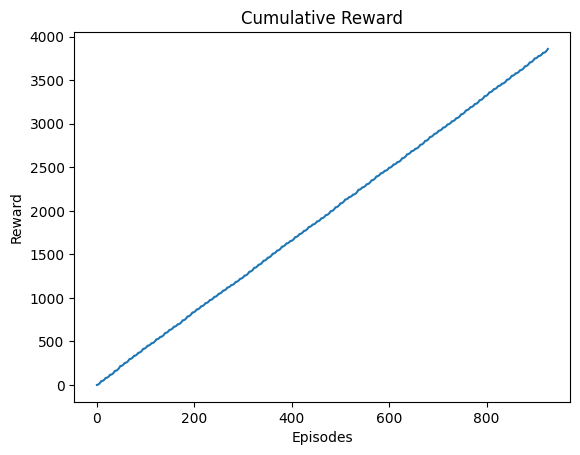

In [44]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [45]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
len(agent.df)

827

In [46]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.0338), tensor(0.2258), tensor(-0.01...  \
1  [[tensor(0.0722), tensor(1.5642), tensor(-0.19...   
2  [[tensor(0.0638), tensor(0.9462), tensor(-0.06...   
3  [[tensor(0.1084), tensor(1.8052), tensor(-0.17...   
4  [[tensor(-0.0373), tensor(0.1903), tensor(-0.0...   

                                    batch_next_state   
0  [[tensor(0.0384), tensor(0.4210), tensor(-0.01...  \
1  [[tensor(-0.0063), tensor(0.0333), tensor(0.02...   
2  [[tensor(0.0828), tensor(1.1420), tensor(-0.09...   
3  [[tensor(-0.0372), tensor(-0.0050), tensor(-0....   
4  [[tensor(-0.0335), tensor(0.3856), tensor(-0.0...   

                                        batch_action   
0  [tensor(1.), tensor(3.), tensor(1.), tensor(8....  \
1  [tensor(8.), tensor(1.), tensor(5.), tensor(6....   
2  [tensor(5.), tensor(7.), tensor(7.), tensor(8....   
3  [tensor(9.), tensor(8.), tensor(5.), tensor(4....   
4  [tensor(1.), tensor(8.), tensor(6.), tensor(4....   

                                        batch_reward  
0  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
1  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
2  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
3  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
4  [tensor(1), tensor(1), tensor(1), tensor(1), t...

In [47]:
agent.df.batch_state.values #cart position, cart velocity, pole angle, pole angular velocity

array([tensor([[ 3.3836e-02,  2.2576e-01, -1.1676e-02, -3.1738e-01],
               [ 3.6601e-02,  5.6877e-01,  3.2786e-02, -7.9417e-01],
               [-1.7677e-02,  1.8221e-01, -3.6655e-03, -3.2469e-01],
               [ 7.2164e-02,  1.5642e+00, -1.9561e-01, -2.4861e+00],
               [ 7.4012e-03,  6.1786e-01,  1.7204e-03, -8.7987e-01],
               [-1.3408e-02,  8.2682e-01, -5.7394e-03, -1.1150e+00],
               [ 1.9758e-02,  8.1296e-01, -1.5877e-02, -1.1720e+00],
               [ 1.5032e-02,  2.2748e-01, -6.2041e-03, -3.2174e-01],
               [ 8.2411e-02,  1.1535e+00, -3.1899e-02, -1.6578e+00],
               [ 1.0825e-01,  1.5957e+00, -1.4595e-01, -2.4106e+00]]),
       tensor([[ 7.2164e-02,  1.5642e+00, -1.9561e-01, -2.4861e+00],
               [-1.7677e-02,  1.8221e-01, -3.6655e-03, -3.2469e-01],
               [ 6.2181e-03,  9.9282e-01, -2.7945e-02, -1.3928e+00],
               [ 5.8640e-02,  1.1258e+00, -5.0822e-02, -1.7147e+00],
               [-3.7008e-02, -2.

In [48]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [49]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 0.0338,  0.2258, -0.0117, -0.3174],
        [ 0.0366,  0.5688,  0.0328, -0.7942],
        [-0.0177,  0.1822, -0.0037, -0.3247],
        ...,
        [-0.0065,  0.5726, -0.0225, -0.9144],
        [ 0.0589,  0.7777, -0.0460, -1.1780],
        [ 0.0726,  1.1385, -0.1272, -1.9010]])


8270

In [50]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 1.0999e-02,  1.1680e+00, -1.2067e-01, -1.8547e+00],
        [ 4.7976e-02,  7.6342e-01,  1.6902e-02, -1.0764e+00],
        [-3.4785e-02,  4.3703e-01,  2.1572e-02, -5.3987e-01],
        [-1.1555e-02,  3.5005e-01, -4.2442e-02, -5.6250e-01],
        [-1.7677e-02,  1.8221e-01, -3.6655e-03, -3.2469e-01],
        [-4.8549e-02,  1.5380e-01,  2.2160e-02, -2.8940e-01],
        [ 1.1956e-01,  1.3997e+00, -1.3997e-01, -2.1589e+00],
        [ 7.6065e-03,  3.4565e-01,  2.7646e-02, -5.5109e-01],
        [ 2.8404e-02,  1.3252e+00, -9.9529e-02, -2.0657e+00],
        [-4.5839e-02, -6.0092e-04, -1.7014e-02, -3.5548e-02],
        [ 3.3687e-04,  9.8719e-01, -8.9397e-02, -1.4873e+00],
        [ 7.5023e-02,  1.1686e+00, -7.7962e-02, -1.7507e+00],
        [-2.5424e-02,  5.8413e-01, -4.4358e-02, -8.8804e-01],
        [-1.7677e-02,  1.8221e-01, -3.6655e-03, -3.2469e-01],
        [-3.9631e-02,  2.4230e-01,  2.6686e-02, -2.5572e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [51]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [52]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [53]:
shap_values

[array([[-2.33586058e-01,  3.89033103e+00,  6.64817929e-01,
          6.07710838e+00],
        [ 6.77357391e-02, -7.52990365e-01, -7.75525749e-01,
         -1.89362621e+00],
        [-6.06666923e-01, -4.49884319e+00, -8.24414134e-01,
         -7.38743210e+00],
        [-4.17371541e-01, -5.49711514e+00, -1.54192552e-01,
         -7.15572357e+00],
        [-4.67253953e-01, -7.42329025e+00, -5.60180724e-01,
         -9.59093571e+00],
        [-7.18823254e-01, -7.74935150e+00, -8.30570698e-01,
         -9.95239162e+00],
        [ 6.51080668e-01,  6.54892063e+00,  8.66956234e-01,
          9.19247723e+00],
        [-2.61227101e-01, -5.54753828e+00, -8.88017416e-01,
         -7.27258348e+00],
        [-9.17545483e-02,  5.69377804e+00,  4.43516374e-01,
          8.23796082e+00],
        [-6.96739614e-01, -9.52135086e+00, -4.20421720e-01,
         -1.25519047e+01],
        [-3.20466161e-01,  1.81514311e+00,  3.37436944e-01,
          2.31503868e+00],
        [ 2.88133353e-01,  3.89761567e+00, 

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

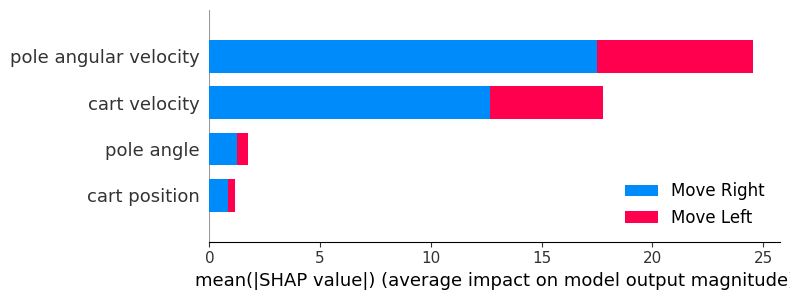

In [54]:
shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'], class_names=['Move Left', 'Move Right']) #env.df.columns not the best

In [55]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'])

### 50,000 Capacity Size

#### Setup Environment

In [56]:
env = gym.make('CartPole-v1')#render_mode='human'
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

2
Discrete(2)
4
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


#### Create Agent

In [57]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 50000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

#### Simulate the environment

In [58]:
episodes = 100
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated #max duration should be 200 for episode length
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-0.17291617 -1.7152275   0.2525236   2.8830059 ], action: 0, score: 9.0
episode: 1, obs: [-0.2139102  -1.9601094   0.26330814  3.1411881 ], action: 0, score: 10.0
episode: 2, obs: [-0.15494037 -1.9233464   0.25764686  3.0764134 ], action: 0, score: 10.0
episode: 3, obs: [-0.14334092 -1.8069208   0.2576907   2.8822355 ], action: 0, score: 9.0
episode: 4, obs: [-0.08622391 -1.5829271   0.22806352  2.5975475 ], action: 0, score: 8.0
episode: 5, obs: [-0.15406969 -1.9863223   0.2567085   3.060729  ], action: 0, score: 10.0
episode: 6, obs: [-0.17216194 -1.7443874   0.2539686   2.900259  ], action: 0, score: 9.0
episode: 7, obs: [-0.19581884 -1.9688151   0.26019233  3.0797472 ], action: 0, score: 10.0
episode: 8, obs: [-0.21304046 -1.9560575   0.23927586  3.06419   ], action: 0, score: 10.0
episode: 9, obs: [-0.14112492 -1.7288822   0.23611663  2.8101854 ], action: 0, score: 9.0
episode: 10, obs: [-0.13639846 -1.9246217   0.251771    3.0667403 ], action: 0, score: 10.0
epi

#### HOW did the agent performed?

##### Agent's final score

In [59]:
#Current sum of all values in the reward window
print(agent.score())

4029.0


##### Rewards at given time/step

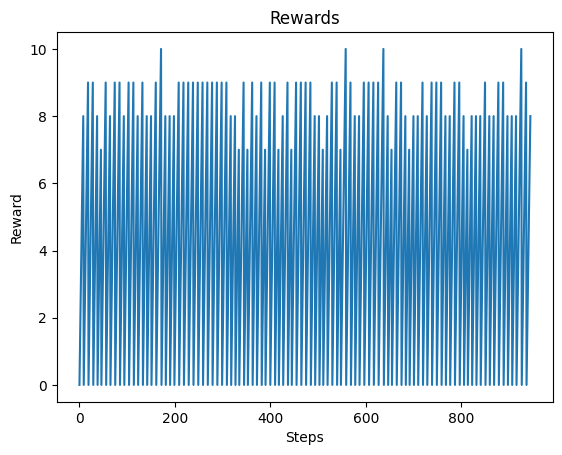

In [60]:
# Iterate over the rows of env.df and append them to df_rewards
for index, row in env.df.iterrows():
    new_row = ["50k", row['time_sec'], row["reward"]]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

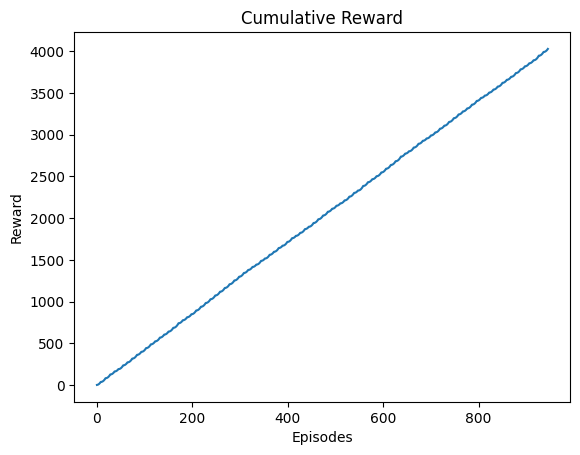

In [61]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [62]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
len(agent.df)

846

In [63]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.1786), tensor(-1.7643), tensor(0.2...  \
1  [[tensor(-0.0606), tensor(-0.7817), tensor(0.0...   
2  [[tensor(-0.0406), tensor(0.0476), tensor(0.02...   
3  [[tensor(-0.0602), tensor(-0.7347), tensor(0.0...   
4  [[tensor(-0.1786), tensor(-1.7643), tensor(0.2...   

                                    batch_next_state   
0  [[tensor(0.0144), tensor(0.0323), tensor(-0.00...  \
1  [[tensor(-0.0762), tensor(-0.9769), tensor(0.0...   
2  [[tensor(-0.0396), tensor(-0.1479), tensor(0.0...   
3  [[tensor(-0.0749), tensor(-0.9306), tensor(0.0...   
4  [[tensor(0.0144), tensor(0.0323), tensor(-0.00...   

                                        batch_action   
0  [tensor(9.), tensor(7.), tensor(6.), tensor(8....  \
1  [tensor(4.), tensor(8.), tensor(8.), tensor(1....   
2  [tensor(0.), tensor(2.), tensor(7.), tensor(7....   
3  [tensor(4.), tensor(8.), tensor(0.), tensor(1....   
4  [tensor(9.), tensor(6.), tensor(2.), tensor(0....   

                                        batch_reward  
0  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
1  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
2  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
3  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
4  [tensor(0), tensor(0), tensor(0), tensor(0), t...

In [64]:
agent.df.batch_state.values #cart position, cart velocity, pole angle, pole angular velocity

array([tensor([[-1.7862e-01, -1.7643e+00,  2.0744e-01,  2.7932e+00],
               [-6.3060e-02, -1.3353e+00,  1.1384e-01,  2.0676e+00],
               [-3.4686e-02, -1.1903e+00,  1.4456e-01,  1.9207e+00],
               [-1.1112e-01, -1.6108e+00,  2.0701e-01,  2.5339e+00],
               [-1.4120e-01, -1.5483e+00,  2.0291e-01,  2.5529e+00],
               [-5.8412e-02, -1.3982e+00,  1.1384e-01,  2.0521e+00],
               [-1.9777e-04, -4.3477e-01,  3.9347e-02,  6.1892e-01],
               [-5.6565e-02, -7.6389e-01,  6.4312e-02,  1.2569e+00],
               [-6.0933e-02, -1.1404e+00,  1.0795e-01,  1.8088e+00],
               [-1.1415e-01, -1.3521e+00,  1.5859e-01,  2.2158e+00]]),
       tensor([[-0.0606, -0.7817,  0.0082,  1.1608],
               [-0.1105, -1.5327,  0.1868,  2.4665],
               [-0.1412, -1.5483,  0.2029,  2.5529],
               [-0.0342, -0.1772,  0.0254,  0.3471],
               [-0.0602, -0.7347,  0.0645,  1.2401],
               [-0.0577, -0.9890,  0.0523, 

In [65]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [66]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.1786, -1.7643,  0.2074,  2.7932],
        [-0.0631, -1.3353,  0.1138,  2.0676],
        [-0.0347, -1.1903,  0.1446,  1.9207],
        ...,
        [-0.1394, -1.5298,  0.1381,  2.3498],
        [ 0.0191, -0.7596,  0.0146,  1.1969],
        [ 0.0062, -0.1519,  0.0280,  0.2993]])


8460

In [67]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-8.7495e-03, -9.6130e-01,  8.3356e-02,  1.5432e+00],
        [-6.5144e-02, -1.5423e+00,  1.4665e-01,  2.4348e+00],
        [-5.3041e-02, -1.3457e+00,  1.1834e-01,  2.1102e+00],
        [-8.8932e-03, -6.3042e-01,  5.1725e-02,  9.2373e-01],
        [-1.4530e-01, -1.9782e+00,  2.0913e-01,  2.9613e+00],
        [ 2.2076e-02, -6.1007e-01, -2.8779e-02,  8.1484e-01],
        [-8.4880e-02, -9.7569e-01,  3.7023e-02,  1.4167e+00],
        [-4.2131e-02, -7.7108e-01,  4.4634e-03,  1.1736e+00],
        [ 8.7095e-03, -1.7952e-01, -4.1724e-02,  2.7087e-01],
        [ 1.4387e-02,  3.2276e-02, -5.6586e-03, -2.7276e-02],
        [ 1.3190e-02, -6.0192e-01,  6.7862e-02,  9.6327e-01],
        [-3.7008e-02, -2.4295e-03, -2.7309e-02,  1.6981e-02],
        [-1.0882e-01, -1.7381e+00,  2.0465e-01,  2.7364e+00],
        [-4.9183e-02, -5.8989e-01,  6.9606e-03,  9.1107e-01],
        [-5.6223e-03, -2.0673e-01, -1.9588e-02,  2.9938e-01],
        [-2.3613e-03, -5.6861e-01, -2.5304e-02,  8.3113e-01],
        

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [68]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [69]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [70]:
shap_values

[array([[-6.92723870e-01,  4.30483913e+00,  4.48140174e-01,
          8.49499321e+00],
        [ 5.58172047e-01,  1.92230434e+01,  1.67416000e+00,
          3.18750801e+01],
        [ 2.89707065e-01,  1.41742411e+01,  1.12567103e+00,
          2.33630085e+01],
        [-6.89536393e-01, -4.19166660e+00, -1.64558351e-01,
         -7.74853182e+00],
        [ 2.33603549e+00,  3.04167118e+01,  2.88429594e+00,
          4.56812401e+01],
        [-1.37647045e+00, -4.71418810e+00, -1.72389460e+00,
         -1.06038971e+01],
        [ 9.95930254e-01,  4.67420006e+00, -4.49330449e-01,
          5.17946053e+00],
        [ 4.77067046e-02, -5.79767227e-01, -1.08000517e+00,
         -1.19517398e+00],
        [-1.07998264e+00, -1.57700539e+01, -1.97464180e+00,
         -2.48683357e+01],
        [-1.20590401e+00, -2.12085342e+01, -1.27606344e+00,
         -3.26865311e+01],
        [-1.17936397e+00, -4.92346525e+00,  1.48021370e-01,
         -6.71171379e+00],
        [-6.59239143e-02, -2.03173523e+01, 

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

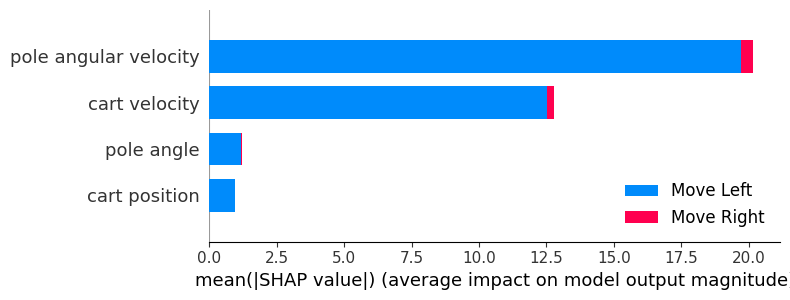

In [71]:
shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'], class_names=['Move Left', 'Move Right']) #env.df.columns not the best

In [72]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'])

### 10,000 Capacity Size

#### Setup Environment

In [73]:
env = gym.make('CartPole-v1')#render_mode='human'
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

2
Discrete(2)
4
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


#### Create Agent

In [74]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 10000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

#### Simulate the environment

In [75]:
episodes = 100
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated #max duration should be 200 for episode length
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [ 0.14446816  2.0011039  -0.23103364 -3.010781  ], action: 1, score: 10.0
episode: 1, obs: [ 0.10267503  1.7564692  -0.22289637 -2.7622514 ], action: 1, score: 9.0
episode: 2, obs: [ 0.16090864  1.793284   -0.22729722 -2.8262067 ], action: 1, score: 9.0
episode: 3, obs: [ 0.17219904  1.9092866  -0.22576128 -3.0090034 ], action: 1, score: 10.0
episode: 4, obs: [ 0.2368995   2.132273   -0.26020768 -3.27619   ], action: 1, score: 11.0
episode: 5, obs: [ 0.16303867  1.7303206  -0.22792827 -2.8417988 ], action: 1, score: 9.0
episode: 6, obs: [ 0.14463854  1.9719316  -0.22925225 -2.9931939 ], action: 1, score: 10.0
episode: 7, obs: [ 0.12094037  1.7478273  -0.22481468 -2.8235598 ], action: 1, score: 9.0
episode: 8, obs: [ 0.10344791  1.760355   -0.24533534 -2.8318627 ], action: 1, score: 9.0
episode: 9, obs: [ 0.17600374  1.9876441  -0.24904364 -3.0893004 ], action: 1, score: 10.0
episode: 10, obs: [ 0.17947324  1.7919693  -0.23297822 -2.8341613 ], action: 1, score: 9.0
epis

#### HOW did the agent performed?

##### Agent's final score

In [76]:
#Current sum of all values in the reward window
print(agent.score())

3860.0


##### Rewards at given time/step

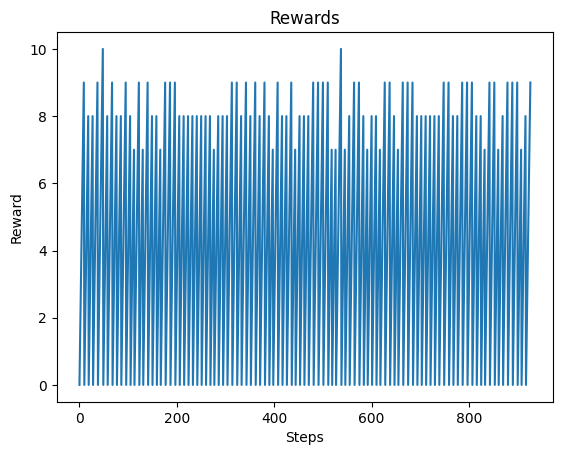

In [77]:
# Iterate over the rows of env.df and append them to df_rewards
for index, row in env.df.iterrows():
    new_row = ["10k", row['time_sec'], row["reward"]]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

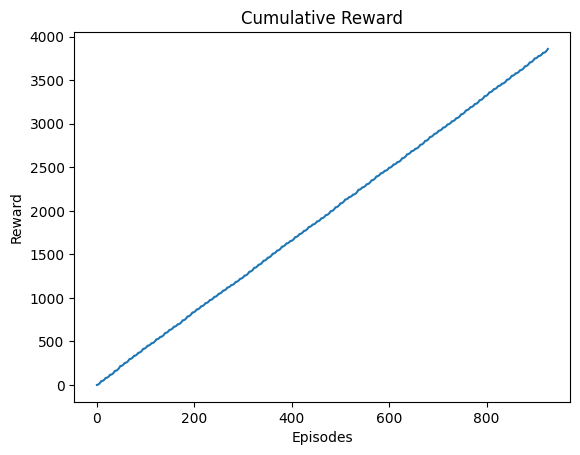

In [78]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [79]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
len(agent.df)

827

In [80]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.0332), tensor(0.0305), tensor(-0.01...  \
1  [[tensor(0.0899), tensor(1.5517), tensor(-0.17...   
2  [[tensor(0.0824), tensor(1.1535), tensor(-0.03...   
3  [[tensor(0.0366), tensor(0.5688), tensor(0.032...   
4  [[tensor(0.0236), tensor(1.2175), tensor(-0.05...   

                                    batch_next_state   
0  [[tensor(0.0338), tensor(0.2258), tensor(-0.01...  \
1  [[tensor(-0.0370), tensor(-0.0024), tensor(-0....   
2  [[tensor(0.1055), tensor(1.3490), tensor(-0.06...   
3  [[tensor(0.0480), tensor(0.7634), tensor(0.016...   
4  [[tensor(0.0479), tensor(1.4132), tensor(-0.09...   

                                        batch_action   
0  [tensor(0.), tensor(7.), tensor(7.), tensor(6....  \
1  [tensor(8.), tensor(9.), tensor(1.), tensor(8....   
2  [tensor(6.), tensor(4.), tensor(2.), tensor(6....   
3  [tensor(3.), tensor(4.), tensor(8.), tensor(2....   
4  [tensor(6.), tensor(8.), tensor(3.), tensor(5....   

                                        batch_reward  
0  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
1  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
2  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
3  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
4  [tensor(1), tensor(1), tensor(1), tensor(1), t...

In [81]:
agent.df.batch_state.values #cart position, cart velocity, pole angle, pole angular velocity

array([tensor([[ 0.0332,  0.0305, -0.0113, -0.0212],
               [ 0.0442,  1.3641, -0.1326, -2.0909],
               [ 0.1009,  1.4010, -0.1345, -2.1537],
               [ 0.0214,  1.1718, -0.1161, -1.8241],
               [ 0.0198,  0.8130, -0.0159, -1.1720],
               [ 0.0628,  1.3556, -0.1321, -2.1523],
               [ 0.0400,  0.9304, -0.0225, -1.4150],
               [ 0.1083,  1.5957, -0.1459, -2.4106],
               [-0.0177,  0.1822, -0.0037, -0.3247],
               [ 0.0562,  1.2039, -0.0687, -1.7743]]),
       tensor([[ 0.0899,  1.5517, -0.1752, -2.4827],
               [ 0.1091,  1.7760, -0.1762, -2.6523],
               [-0.0373,  0.1903, -0.0121, -0.2541],
               [ 0.0722,  1.5642, -0.1956, -2.4861],
               [ 0.0468,  0.6164, -0.0303, -0.9120],
               [ 0.1324,  1.5342, -0.1779, -2.5003],
               [ 0.1982,  1.9366, -0.2016, -2.9297],
               [ 0.0488,  0.7505, -0.0423, -1.2295],
               [ 0.0338,  0.2258, -0.0117, -

In [82]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [83]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 0.0332,  0.0305, -0.0113, -0.0212],
        [ 0.0442,  1.3641, -0.1326, -2.0909],
        [ 0.1009,  1.4010, -0.1345, -2.1537],
        ...,
        [ 0.0853,  1.3268, -0.1158, -2.1222],
        [-0.0051,  0.1703, -0.0258, -0.2763],
        [-0.0092,  0.8249, -0.0032, -1.1298]])


8270

In [84]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 1.6335e-01,  1.7407e+00, -1.4971e-01, -2.5953e+00],
        [-5.6223e-03,  1.8350e-01, -1.9588e-02, -2.8585e-01],
        [-3.9631e-02,  2.4230e-01,  2.6686e-02, -2.5572e-01],
        [ 3.2512e-02,  9.6576e-01, -7.8487e-02, -1.4986e+00],
        [ 9.1454e-02,  1.5749e+00, -1.9837e-01, -2.4765e+00],
        [ 1.2286e-01,  1.7759e+00, -2.0279e-01, -2.7278e+00],
        [ 1.6244e-02,  1.8530e-01,  3.0736e-02, -3.1591e-01],
        [ 5.9100e-02,  8.1193e-01, -4.8538e-02, -1.2141e+00],
        [ 3.2647e-02,  4.1208e-01, -1.1860e-02, -6.1147e-01],
        [ 1.3235e-01,  1.5342e+00, -1.7792e-01, -2.5003e+00],
        [-2.7399e-02,  5.9553e-01, -4.8558e-02, -8.6721e-01],
        [-4.1084e-03,  6.8741e-03, -3.6020e-02, -3.8547e-02],
        [ 9.6942e-02,  1.3561e+00, -9.3376e-02, -2.0783e+00],
        [ 1.6840e-02, -2.8904e-03,  6.5236e-03,  2.6500e-02],
        [ 8.2752e-02,  1.1420e+00, -9.7579e-02, -1.8479e+00],
        [ 2.1191e-02,  9.3752e-01, -9.4603e-02, -1.4914e+00],
        

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [85]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [86]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [87]:
shap_values

[array([[ 1.23126578e+00,  1.15843992e+01,  9.12574053e-01,
          1.55640364e+01],
        [-4.38105613e-01, -7.89046049e+00, -3.64610106e-01,
         -1.09515018e+01],
        [-7.74086893e-01, -7.15509987e+00, -8.18813264e-01,
         -1.12973814e+01],
        [-6.13619983e-02,  1.89299691e+00,  2.13513568e-01,
          2.97252774e+00],
        [ 5.20942926e-01,  9.51174641e+00,  1.39020276e+00,
          1.42009315e+01],
        [ 8.31215918e-01,  1.20252676e+01,  1.43364501e+00,
          1.70861168e+01],
        [-2.22081080e-01, -7.86802340e+00, -8.58566344e-01,
         -1.06063147e+01],
        [ 2.01302588e-01, -3.08542904e-02, -8.04541036e-02,
         -2.94104129e-01],
        [-6.00371771e-02, -5.03167057e+00, -4.40461934e-01,
         -7.21289682e+00],
        [ 9.25002813e-01,  9.00273991e+00,  1.18951797e+00,
          1.44733295e+01],
        [-6.53247178e-01, -2.73730397e+00, -8.02557394e-02,
         -4.27668095e+00],
        [-4.23150122e-01, -1.00995064e+01, 

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

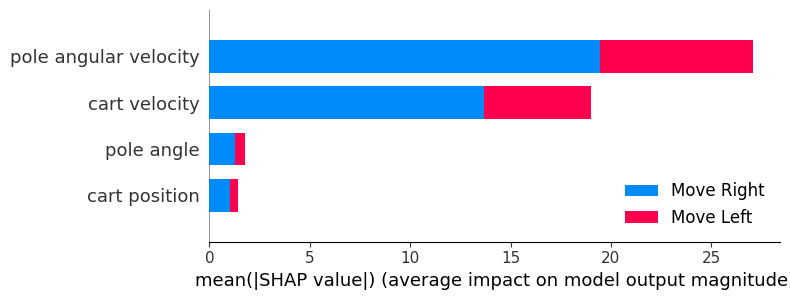

In [88]:
shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'], class_names=['Move Left', 'Move Right']) #env.df.columns not the best

In [89]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'])

### 5,000 Capacity Size

#### Setup Environment

In [90]:
env = gym.make('CartPole-v1')#render_mode='human'
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

2
Discrete(2)
4
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


#### Create Agent

In [91]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 5000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

#### Simulate the environment

In [92]:
episodes = 100
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated #max duration should be 200 for episode length
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [ 0.14446816  2.0011039  -0.23103364 -3.010781  ], action: 1, score: 10.0
episode: 1, obs: [ 0.10267503  1.7564692  -0.22289637 -2.7622514 ], action: 1, score: 9.0
episode: 2, obs: [ 0.16090864  1.793284   -0.22729722 -2.8262067 ], action: 1, score: 9.0
episode: 3, obs: [ 0.17219904  1.9092866  -0.22576128 -3.0090034 ], action: 1, score: 10.0
episode: 4, obs: [ 0.2368995   2.132273   -0.26020768 -3.27619   ], action: 1, score: 11.0
episode: 5, obs: [ 0.16303867  1.7303206  -0.22792827 -2.8417988 ], action: 1, score: 9.0
episode: 6, obs: [ 0.14463854  1.9719316  -0.22925225 -2.9931939 ], action: 1, score: 10.0
episode: 7, obs: [ 0.12094037  1.7478273  -0.22481468 -2.8235598 ], action: 1, score: 9.0
episode: 8, obs: [ 0.10344791  1.760355   -0.24533534 -2.8318627 ], action: 1, score: 9.0
episode: 9, obs: [ 0.17600374  1.9876441  -0.24904364 -3.0893004 ], action: 1, score: 10.0
episode: 10, obs: [ 0.17947324  1.7919693  -0.23297822 -2.8341613 ], action: 1, score: 9.0
epis

#### HOW did the agent performed?

##### Agent's final score

In [93]:
#Current sum of all values in the reward window
print(agent.score())

3860.0


##### Rewards at given time/step

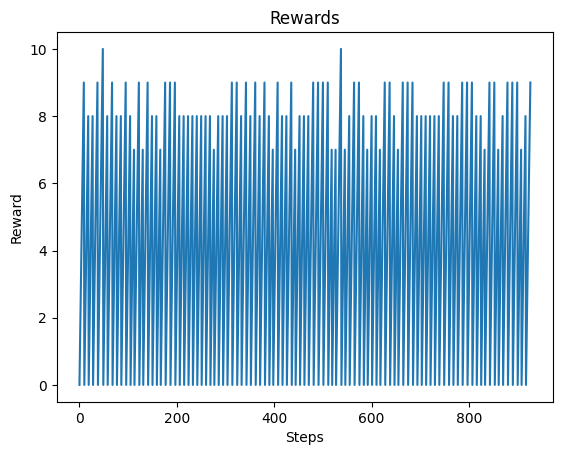

In [94]:
# Iterate over the rows of env.df and append them to df_rewards
for index, row in env.df.iterrows():
    new_row = ["5k", row['time_sec'], row["reward"]]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

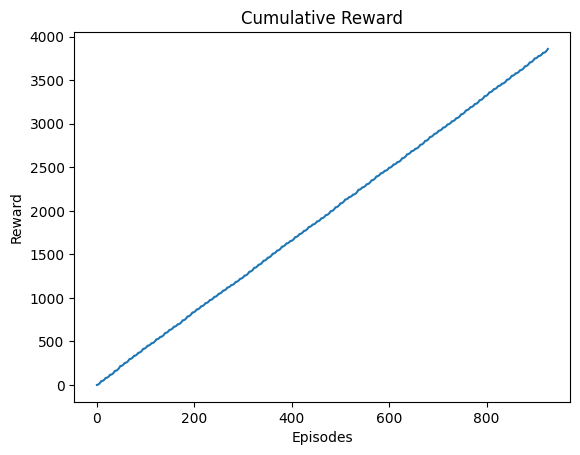

In [95]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [96]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
len(agent.df)

827

In [97]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.0366), tensor(0.5688), tensor(0.032...  \
1  [[tensor(-0.0342), tensor(0.2131), tensor(0.02...   
2  [[tensor(0.0272), tensor(0.1646), tensor(-0.00...   
3  [[tensor(0.0899), tensor(1.5517), tensor(-0.17...   
4  [[tensor(0.0258), tensor(-0.0145), tensor(0.04...   

                                    batch_next_state   
0  [[tensor(0.0480), tensor(0.7634), tensor(0.016...  \
1  [[tensor(-0.0299), tensor(0.4078), tensor(0.02...   
2  [[tensor(0.0305), tensor(0.3598), tensor(-0.01...   
3  [[tensor(-0.0370), tensor(-0.0024), tensor(-0....   
4  [[tensor(0.0255), tensor(0.1799), tensor(0.047...   

                                        batch_action   
0  [tensor(3.), tensor(0.), tensor(4.), tensor(8....  \
1  [tensor(1.), tensor(2.), tensor(4.), tensor(3....   
2  [tensor(1.), tensor(6.), tensor(7.), tensor(2....   
3  [tensor(8.), tensor(3.), tensor(1.), tensor(1....   
4  [tensor(0.), tensor(6.), tensor(4.), tensor(4....   

                                        batch_reward  
0  [tensor(1), tensor(0), tensor(1), tensor(1), t...  
1  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
2  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
3  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
4  [tensor(1), tensor(1), tensor(1), tensor(1), t...

In [98]:
agent.df.batch_state.values #cart position, cart velocity, pole angle, pole angular velocity

array([tensor([[ 0.0366,  0.5688,  0.0328, -0.7942],
               [ 0.0000,  0.0000,  0.0000,  0.0000],
               [-0.0137,  0.7798, -0.0621, -1.1943],
               [ 0.1290,  1.5972, -0.1776, -2.4847],
               [ 0.1083,  1.5957, -0.1459, -2.4106],
               [-0.0348,  0.4370,  0.0216, -0.5399],
               [ 0.0586,  1.1258, -0.0508, -1.7147],
               [ 0.0338,  0.2258, -0.0117, -0.3174],
               [ 0.0272,  0.1646, -0.0042, -0.3394],
               [ 0.1076,  1.5173, -0.1256, -2.3405]]),
       tensor([[-0.0342,  0.2131,  0.0254, -0.2381],
               [-0.0348,  0.4370,  0.0216, -0.5399],
               [ 0.0480,  0.7634,  0.0169, -1.0764],
               [-0.0065,  0.5726, -0.0225, -0.9144],
               [ 0.1290,  1.5972, -0.1776, -2.4847],
               [ 0.0498,  1.3840, -0.0897, -2.0036],
               [-0.0254,  0.5841, -0.0444, -0.8880],
               [ 0.0258, -0.0145,  0.0471,  0.0393],
               [-0.0134,  0.8268, -0.0057, -

In [99]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [100]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 0.0366,  0.5688,  0.0328, -0.7942],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0137,  0.7798, -0.0621, -1.1943],
        ...,
        [-0.0122,  0.9517, -0.0960, -1.5194],
        [ 0.0333,  0.4184,  0.0381, -0.5814],
        [ 0.1076,  1.5173, -0.1256, -2.3405]])


8270

In [101]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 2.1370e-02,  1.1718e+00, -1.1612e-01, -1.8241e+00],
        [-2.2131e-02,  5.8696e-01, -5.1795e-02, -8.9216e-01],
        [ 5.1828e-02,  1.1617e+00, -1.0846e-01, -1.8147e+00],
        [-1.3716e-02,  8.2136e-01, -4.2144e-02, -1.2145e+00],
        [-5.6195e-03,  2.2810e-01,  1.9651e-02, -3.0506e-01],
        [ 3.6182e-02,  1.3691e+00, -1.4856e-01, -2.1874e+00],
        [ 1.2897e-01,  1.5972e+00, -1.7760e-01, -2.4847e+00],
        [ 3.8191e-02,  3.6485e-01, -5.1170e-02, -6.3456e-01],
        [ 1.0759e-01,  1.5173e+00, -1.2557e-01, -2.3405e+00],
        [ 1.5032e-02,  2.2748e-01, -6.2041e-03, -3.2174e-01],
        [-4.8549e-02,  1.5380e-01,  2.2160e-02, -2.8940e-01],
        [ 6.3564e-02,  1.5653e+00, -1.9230e-01, -2.5220e+00],
        [ 5.8165e-03,  1.1294e+00, -6.4455e-02, -1.7537e+00],
        [-3.4205e-02,  2.1307e-01,  2.5411e-02, -2.3811e-01],
        [-1.1555e-02,  3.5005e-01, -4.2442e-02, -5.6250e-01],
        [ 1.2365e-01,  1.5692e+00, -1.6271e-01, -2.4471e+00],
        

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [102]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [103]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [104]:
shap_values

[array([[-1.83598682e-01,  4.51603651e+00,  6.85770214e-01,
          7.80764532e+00],
        [-6.31676376e-01, -2.87310195e+00, -5.91160282e-02,
         -4.55176115e+00],
        [ 1.30137354e-01,  4.38955164e+00,  5.97032011e-01,
          7.68348932e+00],
        [-5.44997990e-01,  8.85977671e-02, -1.70873493e-01,
         -2.77255982e-01],
        [-4.61602598e-01, -7.40756607e+00, -8.86440933e-01,
         -1.23382111e+01],
        [-3.10265869e-02,  7.00990963e+00,  1.06133473e+00,
          1.26266022e+01],
        [ 9.24700439e-01,  9.89158249e+00,  1.39768672e+00,
          1.65697498e+01],
        [-1.03317779e-02, -5.67962742e+00, -6.63570017e-02,
         -7.96829319e+00],
        [ 7.04472661e-01,  8.88282204e+00,  7.95173407e-01,
          1.46569405e+01],
        [-2.48879194e-01, -7.41537571e+00, -5.87044299e-01,
         -1.21170197e+01],
        [-9.03799951e-01, -8.34634399e+00, -9.15487111e-01,
         -1.25459709e+01],
        [ 2.51028866e-01,  9.48921394e+00, 

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

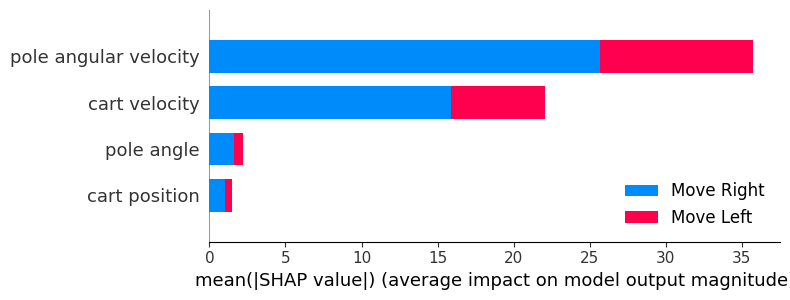

In [105]:
shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'], class_names=['Move Left', 'Move Right']) #env.df.columns not the best

In [106]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'])

### 1,000 Capacity Size

#### Setup Environment

In [107]:
env = gym.make('CartPole-v1')#render_mode='human'
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

2
Discrete(2)
4
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


#### Create Agent

In [108]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 1000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

#### Simulate the environment

In [109]:
episodes = 100
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated #max duration should be 200 for episode length
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [ 0.13667299  1.2224658  -0.21944085 -1.8570014 ], action: 0, score: 10.0
episode: 1, obs: [ 0.09488013  1.3671417  -0.21130672 -2.1833863 ], action: 1, score: 9.0
episode: 2, obs: [ 0.15311402  1.0146358  -0.21571094 -1.6726928 ], action: 0, score: 9.0
episode: 3, obs: [ 0.17141698  0.9379035  -0.22774422 -1.6168355 ], action: 0, score: 11.0
episode: 4, obs: [ 0.2135177   0.9648956  -0.22539264 -1.5426166 ], action: 0, score: 11.0
episode: 5, obs: [ 0.15524405  0.95167947 -0.21634199 -1.6883291 ], action: 0, score: 9.0
episode: 6, obs: [ 0.1368432   1.1932641  -0.21765755 -1.8391402 ], action: 0, score: 10.0
episode: 7, obs: [ 0.11314539  0.96913075 -0.21322411 -1.669537  ], action: 0, score: 9.0
episode: 8, obs: [ 0.09565621  0.9820817  -0.23378362 -1.6823633 ], action: 0, score: 9.0
episode: 9, obs: [ 0.16041331  1.2092468  -0.2257848  -1.9318392 ], action: 0, score: 10.0
episode: 10, obs: [ 0.17167947  1.0134332  -0.2214019  -1.6818295 ], action: 0, score: 9.0
epis

#### HOW did the agent performed?

##### Agent's final score

In [110]:
#Current sum of all values in the reward window
print(agent.score())

3880.0


##### Rewards at given time/step

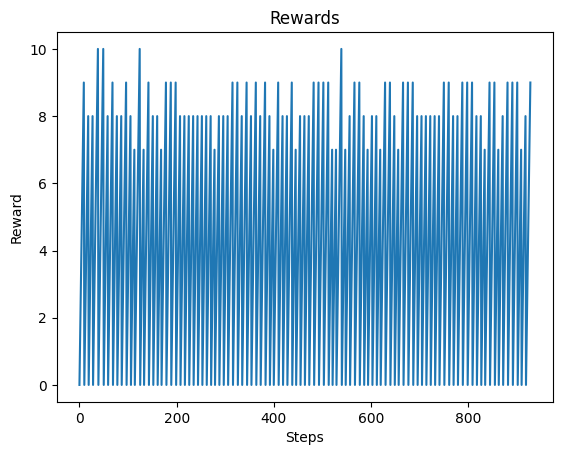

In [111]:
# Iterate over the rows of env.df and append them to df_rewards
for index, row in env.df.iterrows():
    new_row = ["1k", row['time_sec'], row["reward"]]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

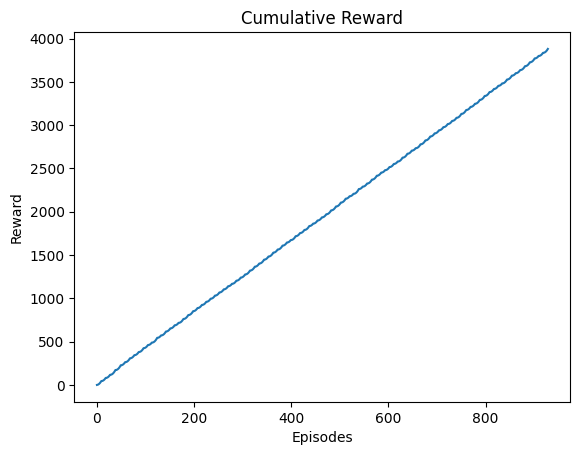

In [112]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [113]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
len(agent.df)

829

In [114]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.0448), tensor(1.3680), tensor(-0.15...  \
1  [[tensor(0.0055), tensor(-0.0436), tensor(0.03...   
2  [[tensor(0.0253), tensor(0.7353), tensor(-7.40...   
3  [[tensor(-0.0254), tensor(0.5841), tensor(-0.0...   
4  [[tensor(0.0261), tensor(1.1883), tensor(-0.05...   

                                    batch_next_state   
0  [[tensor(0.0722), tensor(1.1746), tensor(-0.19...  \
1  [[tensor(0.0046), tensor(0.1510), tensor(0.033...   
2  [[tensor(0.0400), tensor(0.9304), tensor(-0.02...   
3  [[tensor(-0.0137), tensor(0.7798), tensor(-0.0...   
4  [[tensor(0.0498), tensor(1.3840), tensor(-0.08...   

                                        batch_action   
0  [tensor(7.), tensor(5.), tensor(2.), tensor(2....  \
1  [tensor(0.), tensor(0.), tensor(9.), tensor(0....   
2  [tensor(4.), tensor(7.), tensor(4.), tensor(3....   
3  [tensor(3.), tensor(6.), tensor(4.), tensor(6....   
4  [tensor(6.), tensor(7.), tensor(3.), tensor(8....   

                                        batch_reward  
0  [tensor(0), tensor(1), tensor(1), tensor(1), t...  
1  [tensor(1), tensor(1), tensor(0), tensor(1), t...  
2  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
3  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
4  [tensor(1), tensor(1), tensor(1), tensor(0), t...

In [115]:
agent.df.batch_state.values #cart position, cart velocity, pole angle, pole angular velocity

array([tensor([[ 0.0448,  1.3680, -0.1526, -2.1505],
               [ 0.0567,  1.0091, -0.0675, -1.5193],
               [-0.0299,  0.4078,  0.0206, -0.5227],
               [ 0.0196,  0.4227, -0.0126, -0.6164],
               [ 0.0488,  0.7505, -0.0423, -1.2295],
               [ 0.1055,  1.3490, -0.0651, -1.9603],
               [ 0.1076,  1.1273, -0.1256, -1.7576],
               [ 0.0562,  1.2039, -0.0687, -1.7743],
               [-0.0346,  0.0183,  0.0245,  0.0468],
               [ 0.0145,  0.5404,  0.0166, -0.8349]]),
       tensor([[ 0.0055, -0.0436,  0.0328,  0.0132],
               [-0.0372, -0.0050, -0.0129,  0.0427],
               [ 0.1324,  1.4022, -0.1825, -2.1631],
               [-0.0174, -0.0130, -0.0030, -0.0311],
               [ 0.0396,  1.1595, -0.0955, -1.8315],
               [ 0.0404,  0.8134, -0.0432, -1.2134],
               [-0.0254,  0.5841, -0.0444, -0.8880],
               [ 0.0046,  0.1510,  0.0330, -0.2690],
               [ 0.0488,  0.7505, -0.0423, -

In [116]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [117]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 4.4805e-02,  1.3680e+00, -1.5260e-01, -2.1505e+00],
        [ 5.6664e-02,  1.0091e+00, -6.7495e-02, -1.5193e+00],
        [-2.9944e-02,  4.0782e-01,  2.0649e-02, -5.2267e-01],
        ...,
        [ 1.5510e-01,  1.7480e+00, -1.8291e-01, -2.7293e+00],
        [ 3.2403e-04,  3.6741e-01, -2.2719e-02, -5.9382e-01],
        [-1.9246e-02,  2.0349e-01, -3.1609e-02, -2.6704e-01]])


8290

In [118]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 1.7529e-02,  1.5951e-01, -3.0994e-02, -3.5126e-01],
        [-4.8549e-02,  1.5380e-01,  2.2160e-02, -2.8940e-01],
        [-1.9523e-03,  3.7890e-01, -2.5305e-02, -5.8465e-01],
        [ 5.3036e-02,  8.0281e-01, -4.2247e-02, -1.2080e+00],
        [ 3.8834e-02,  7.4646e-01, -7.0250e-02, -1.2662e+00],
        [-1.1555e-02,  3.5005e-01, -4.2442e-02, -5.6250e-01],
        [ 6.3564e-02,  1.5653e+00, -1.9230e-01, -2.5220e+00],
        [ 5.5564e-02,  9.7296e-01, -4.9100e-02, -1.4431e+00],
        [ 6.9092e-02,  9.9845e-01, -6.6408e-02, -1.5136e+00],
        [ 3.5711e-02,  9.8566e-01, -1.0087e-01, -1.5778e+00],
        [ 4.0032e-02,  9.3039e-01, -2.2521e-02, -1.4150e+00],
        [ 2.0330e-02,  9.6369e-01, -6.5099e-02, -1.5193e+00],
        [ 5.6700e-02,  7.5657e-01, -8.2719e-02, -1.2550e+00],
        [ 4.6772e-02,  6.1641e-01, -3.0298e-02, -9.1203e-01],
        [ 8.9061e-02,  1.1943e+00, -9.6680e-02, -1.8263e+00],
        [-1.3408e-02,  8.2682e-01, -5.7394e-03, -1.1150e+00],
        

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [119]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [120]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [121]:
shap_values

[array([[-2.65743554e-01, -8.36560249e+00, -3.24997932e-01,
         -1.07565517e+01],
        [-1.08132637e+00, -8.44053459e+00, -9.26006436e-01,
         -1.15294571e+01],
        [-5.06196737e-01, -5.48795938e+00, -3.89325231e-01,
         -7.84082890e+00],
        [ 1.72504872e-01,  7.23978728e-02, -1.97764471e-01,
         -5.28907478e-02],
        [-2.77606607e-03, -6.66672826e-01,  1.18861705e-01,
          6.74564183e-01],
        [-6.24723673e-01, -5.86640978e+00, -1.95566297e-01,
         -8.11752701e+00],
        [ 3.02453101e-01,  1.00743380e+01,  1.49891603e+00,
          1.63631401e+01],
        [ 2.03706712e-01,  2.30422139e+00, -1.20282732e-01,
          2.88386846e+00],
        [ 3.70682329e-01,  2.63859701e+00,  7.54152238e-02,
          3.76524615e+00],
        [-4.13298868e-02,  2.47082782e+00,  4.65038329e-01,
          4.56690884e+00],
        [ 1.20107876e-02,  1.74587619e+00, -4.20807362e-01,
          2.53353739e+00],
        [-2.31175750e-01,  2.18266869e+00, 

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

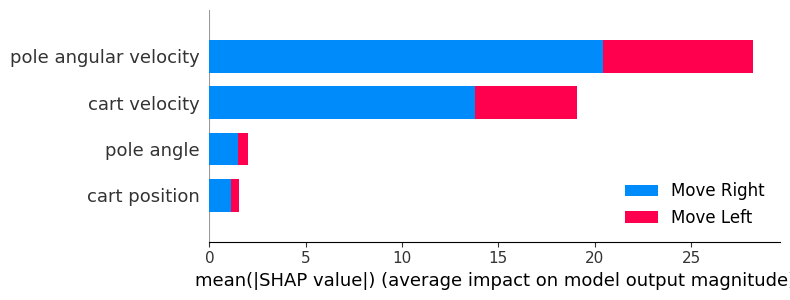

In [122]:
shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'], class_names=['Move Left', 'Move Right']) #env.df.columns not the best

In [123]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'])

### 500 Capacity Size

#### Setup Environment

In [124]:
env = gym.make('CartPole-v1')#render_mode='human'
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

2
Discrete(2)
4
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


#### Create Agent

In [125]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 500 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

#### Simulate the environment

In [126]:
episodes = 100
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated #max duration should be 200 for episode length
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-0.15732966 -1.3261948   0.22931302  2.3009882 ], action: 0, score: 9.0
episode: 1, obs: [-0.19076394 -0.9891701   0.23248729  1.7360094 ], action: 0, score: 11.0
episode: 2, obs: [-0.1388604  -0.952469    0.23744717  1.6785395 ], action: 1, score: 11.0
episode: 3, obs: [-0.11996625 -1.0288204   0.22296835  1.7247655 ], action: 0, score: 9.0
episode: 4, obs: [-0.09450682 -1.0011581   0.24511795  1.7916639 ], action: 1, score: 9.0
episode: 5, obs: [-0.13143137 -1.0149254   0.22399591  1.6469787 ], action: 1, score: 11.0
episode: 6, obs: [-0.14878498 -0.96619666  0.21922024  1.7418617 ], action: 0, score: 9.0
episode: 7, obs: [-0.18065117 -0.99803364  0.24008337  1.6832163 ], action: 1, score: 11.0
episode: 8, obs: [-0.20539483 -0.9847232   0.23044837  1.6659026 ], action: 1, score: 11.0
episode: 9, obs: [-0.1333318  -0.95041996  0.22454816  1.6586967 ], action: 1, score: 9.0
episode: 10, obs: [-0.11300734 -1.1460928   0.2167207   1.9009483 ], action: 1, score: 10.0
epi

#### HOW did the agent performed?

##### Agent's final score

In [127]:
#Current sum of all values in the reward window
print(agent.score())

4097.0


##### Rewards at given time/step

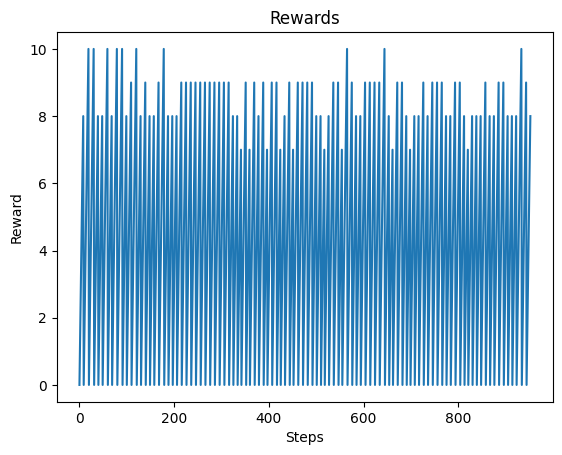

In [128]:
# Iterate over the rows of env.df and append them to df_rewards
for index, row in env.df.iterrows():
    new_row = ["500", row['time_sec'], row["reward"]]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

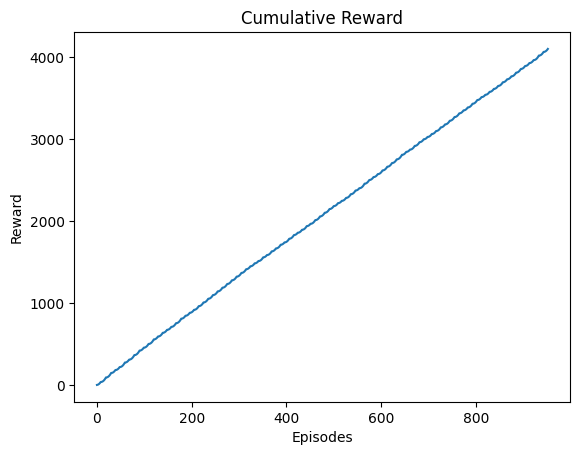

In [129]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [130]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
len(agent.df)

853

In [131]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.0910), tensor(-1.1558), tensor(0.1...  \
1  [[tensor(-0.0218), tensor(-0.4031), tensor(0.0...   
2  [[tensor(-0.0762), tensor(-0.9769), tensor(0.0...   
3  [[tensor(-0.1622), tensor(-0.9807), tensor(0.1...   
4  [[tensor(-0.0370), tensor(-0.0024), tensor(-0....   

                                    batch_next_state   
0  [[tensor(-0.1142), tensor(-0.9622), tensor(0.1...  \
1  [[tensor(-0.0299), tensor(-0.5982), tensor(0.0...   
2  [[tensor(-0.0957), tensor(-1.1724), tensor(0.0...   
3  [[tensor(-0.1818), tensor(-1.1773), tensor(0.1...   
4  [[tensor(-0.0371), tensor(-0.1971), tensor(-0....   

                                        batch_action   
0  [tensor(6.), tensor(1.), tensor(0.), tensor(9....  \
1  [tensor(2.), tensor(1.), tensor(1.), tensor(4....   
2  [tensor(5.), tensor(4.), tensor(10.), tensor(0...   
3  [tensor(9.), tensor(6.), tensor(8.), tensor(0....   
4  [tensor(0.), tensor(9.), tensor(7.), tensor(4....   

                                        batch_reward  
0  [tensor(1), tensor(0), tensor(0), tensor(0), t...  
1  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
2  [tensor(0), tensor(0), tensor(1), tensor(0), t...  
3  [tensor(0), tensor(1), tensor(0), tensor(0), t...  
4  [tensor(0), tensor(0), tensor(1), tensor(0), t...

In [132]:
agent.df.batch_state.values #cart position, cart velocity, pole angle, pole angular velocity

array([tensor([[-0.0910, -1.1558,  0.1208,  1.8882],
               [ 0.0046, -0.2392,  0.0330,  0.3160],
               [ 0.0055, -0.0436,  0.0328,  0.0132],
               [-0.1622, -0.9807,  0.1615,  1.5548],
               [-0.1120, -0.9821,  0.1040,  1.5460],
               [-0.0492, -0.5899,  0.0070,  0.9111],
               [-0.0271, -0.7486,  0.0544,  1.1835],
               [-0.0413, -0.3948, -0.0054,  0.6201],
               [-0.1210, -0.7971,  0.1460,  1.2317],
               [-0.0706, -1.1936,  0.2048,  2.0146]]),
       tensor([[-0.0218, -0.4031,  0.0015,  0.5522],
               [ 0.0255, -0.2103,  0.0479,  0.3465],
               [ 0.0150, -0.1628, -0.0062,  0.2636],
               [-0.0566, -0.7639,  0.0643,  1.2569],
               [-0.0406,  0.0476,  0.0261,  0.0286],
               [-0.0577, -0.9890,  0.0523,  1.4438],
               [ 0.0213, -0.4061,  0.0548,  0.6538],
               [-0.0492, -0.5899,  0.0070,  0.9111],
               [-0.0631, -0.9452,  0.1138,  

In [133]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [134]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.0910, -1.1558,  0.1208,  1.8882],
        [ 0.0046, -0.2392,  0.0330,  0.3160],
        [ 0.0055, -0.0436,  0.0328,  0.0132],
        ...,
        [-0.0932, -1.3304,  0.1506,  2.1415],
        [-0.0394, -0.2423, -0.0451,  0.2458],
        [ 0.0431, -0.0380, -0.0383, -0.0412]])


8530

In [135]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-9.3043e-02, -1.5679e+00,  1.7849e-01,  2.4860e+00],
        [-3.4571e-02,  1.8305e-02,  2.4476e-02,  4.6751e-02],
        [-1.3697e-01, -9.9378e-01,  1.7061e-01,  1.5664e+00],
        [ 2.6291e-02, -1.7308e-01, -6.5361e-03,  3.0326e-01],
        [ 1.7529e-02, -2.3070e-01, -3.0994e-02,  2.3380e-01],
        [ 1.2915e-02, -4.2537e-01, -2.6318e-02,  5.1655e-01],
        [ 4.1257e-02, -1.7481e-01, -2.2475e-02,  3.3212e-01],
        [-2.8058e-02, -1.1500e+00,  8.0016e-02,  1.7575e+00],
        [-1.8843e-01, -1.7638e+00,  1.7835e-01,  2.6861e+00],
        [ 2.7838e-02, -3.0536e-02, -3.3279e-03, -4.5620e-02],
        [-3.9556e-02, -1.5480e-01, -5.0176e-03,  2.6152e-01],
        [ 2.9022e-02, -1.7892e-01,  2.1078e-02,  3.2716e-01],
        [ 2.6291e-02, -1.7308e-01, -6.5361e-03,  3.0326e-01],
        [-1.0728e-01, -1.2076e+00,  1.8647e-01,  1.8765e+00],
        [-4.8169e-02, -1.1537e+00,  4.1747e-02,  1.7026e+00],
        [ 3.0546e-02, -3.5944e-01, -6.3166e-03,  5.5692e-01],
        

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [136]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [137]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [138]:
shap_values

[array([[ 1.28520620e+00,  2.66953163e+01,  3.04137111e+00,
          4.66966896e+01],
        [-3.55733454e-01, -2.39797306e+01, -1.22106969e+00,
         -3.76836815e+01],
        [ 2.51785970e+00,  8.35442543e+00,  2.82345152e+00,
          1.48849297e+01],
        [-2.06375432e+00, -1.78654423e+01, -2.07936478e+00,
         -2.88100910e+01],
        [-1.81786084e+00, -1.60243778e+01, -2.75627351e+00,
         -3.12129803e+01],
        [-1.68837440e+00, -9.80521679e+00, -2.62686038e+00,
         -2.14318085e+01],
        [-2.48377419e+00, -1.78101501e+01, -2.52047944e+00,
         -2.78117580e+01],
        [-5.38511217e-01,  1.33446426e+01,  3.16055894e-01,
          2.14980774e+01],
        [ 3.96204662e+00,  3.29543037e+01,  3.03766584e+00,
          5.36207275e+01],
        [-2.10718155e+00, -2.24193420e+01, -1.99057806e+00,
         -4.08790855e+01],
        [-2.15844542e-01, -1.84494305e+01, -2.03734279e+00,
         -3.02540989e+01],
        [-2.14040160e+00, -1.76786022e+01, 

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

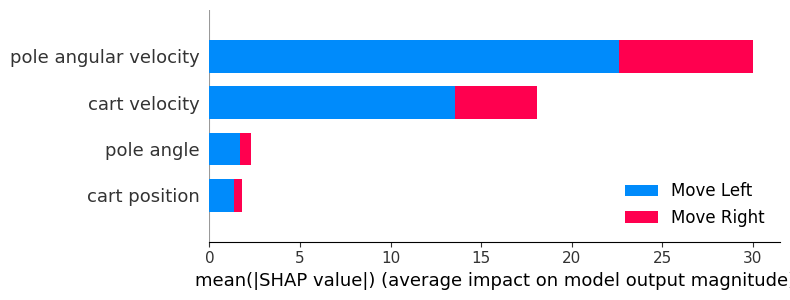

In [139]:
shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'], class_names=['Move Left', 'Move Right']) #env.df.columns not the best

In [140]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['cart position',	'cart velocity', 'pole angle', 'pole angular velocity'])

## ANOVA

In [ ]:
df_rewards.tail()

capacity    time_sec      reward
28803      500  239.733333  132.925375
28804      500  239.800000  132.925375
28805      500  239.866667  132.925375
28806      500  239.933333  132.925375
28807      500  240.000000  132.925375

In [ ]:
x = datetime.datetime.now()
file_name = str(x.year) + "_" + str(x.month) + "_" + str(x.day) + "_" + str(x.strftime("%H")) + "_" + str(x.strftime("%M")) + "_" + str(x.strftime("%S")) + "_cart_pole" + ".csv"
df_rewards.to_csv(file_name, index=False, encoding='utf-8')

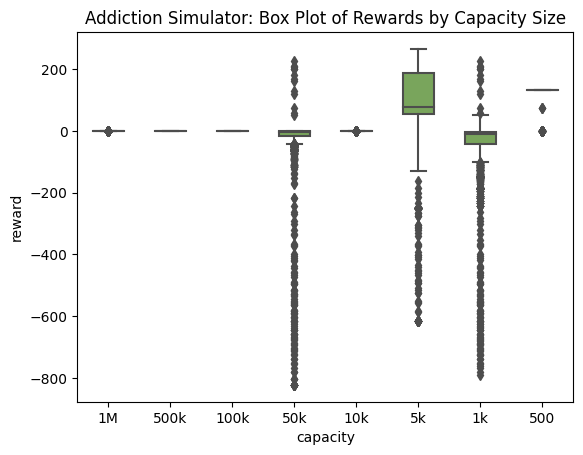

In [ ]:
ax = sns.boxplot(x='capacity', y='reward', data=df_rewards, color='#77B150', width=0.5).set(title='CartPole Simulator: Box Plot of Rewards by Capacity Size')
plt.show()

In [ ]:
# Perform ANOVA and obtain group means
model = ols('reward ~ C(capacity)', data=df_rewards).fit()

In [ ]:
group_means = df_rewards.groupby('capacity')['reward'].mean()
print(group_means)

capacity
100k      0.000000
10k      -0.998889
1M       -0.998889
1k      -42.631552
500     129.111378
500k      0.000000
50k     -29.920466
5k       83.767424
Name: reward, dtype: float64


In [ ]:
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                   sum_sq       df            F  PR(>F)
C(capacity)  8.645837e+07      7.0  2584.636845     0.0
Residual     1.376265e+08  28800.0          NaN     NaN


p-value (PR(>F)): 0.0 indicates that the p-value is extremely small (below the typical threshold of 0.05), suggesting strong evidence to reject the null hypothesis. This means that there is a significant difference between at least two group means of the "capacity" variable.

 "capacity" variable has a significant effect on the "reward" variable. F-statistic is large, further supporting the conclusion that the means of the different "capacity" groups are significantly different from each other.

In [ ]:
# Perform Tukey's HSD test
mc_results = mc.MultiComparison(df_rewards['reward'], df_rewards['capacity'])
tukey_results = mc_results.tukeyhsd()

In [ ]:
# Print the results
print(tukey_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
  100k    10k   -0.9989 0.9987    -5.937    3.9392  False
  100k     1M   -0.9989 0.9987    -5.937    3.9392  False
  100k     1k  -42.6316    0.0  -47.5696  -37.6935   True
  100k    500  129.1114    0.0  124.1733  134.0495   True
  100k   500k       0.0    1.0   -4.9381    4.9381  False
  100k    50k  -29.9205    0.0  -34.8586  -24.9824   True
  100k     5k   83.7674    0.0   78.8293   88.7055   True
   10k     1M       0.0    1.0   -4.9381    4.9381  False
   10k     1k  -41.6327    0.0  -46.5708  -36.6946   True
   10k    500  130.1103    0.0  125.1722  135.0484   True
   10k   500k    0.9989 0.9987   -3.9392     5.937  False
   10k    50k  -28.9216    0.0  -33.8597  -23.9835   True
   10k     5k   84.7663    0.0   79.8282   89.7044   True
    1M     1k  -41.6327    0.0  -46.5708  -36.6946   True
    1M    500 